## BERT Base-Cased Model on GoEmotions

In [1]:
# !pip install -q transformers

In [2]:
# !pip install -q datasets

In [54]:
# importing libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import classification_report
from transformers import BertTokenizer, TFBertModel
from bert_model_class import BertClassificationModel # Imports the BERT model 

In [32]:
from tensorflow import keras

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

from sklearn.preprocessing import MultiLabelBinarizer

from datasets import load_dataset

In [33]:
train_df = pd.read_csv("go_emotions__train_clean.tsv", delimiter='\t')
dev_df = pd.read_csv("go_emotions__val_clean.tsv", delimiter='\t')
test_df = pd.read_csv("go_emotions_test_clean.tsv", delimiter='\t')

In [34]:
# Convert to pandas dataframes
train_df.columns = ["text", "emotions", "ids"]
dev_df.columns = ["text", "emotions", "ids"]
test_df.columns = ["text", "emotions", "ids"]

train_df = train_df.dropna(subset=['text'])
dev_df = dev_df.dropna(subset=['text'])
test_df = test_df.dropna(subset=['text'])

train_texts = train_df['text'].tolist()
dev_texts = dev_df['text'].tolist()
test_texts = test_df['text'].tolist()

In [35]:
train_df[:10]

,text,emotions,ids
0,my favourite food is anything i did not have t...,[28],eebbqej
1,now if he does off himself everyone will think...,[28],ed00q6i
2,why the fuck is bayless isoing,[3],eezlygj
3,to make her feel threatened,[15],ed7ypvh
4,dirty southern wankers,[4],ed0bdzj
5,omg peyton is not good enough to help us in th...,[27],edvnz26
6,yes i heard about the f bombs that has to be w...,[16],ee3b6wu
7,we need more boards and to create a bit more s...,"[9, 21]",ef4qmod
8,damn youtube and outrage drama is super lucrat...,[1],ed8wbdn
9,it might be linked to the trust factor of your...,[28],eczgv1o


In [51]:
len(train_df)

43406

In [36]:
# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit on the training data and transform
train_labels_bin = mlb.fit_transform(train_df["emotions"].tolist())
dev_labels_bin = mlb.transform(dev_df["emotions"].tolist())
test_labels_bin = mlb.transform(test_df["emotions"].tolist())

In [37]:
train_labels_bin

array([[0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 1, 1]])

In [39]:
# del dataset, train_df, dev_df, test_df

In [40]:
emotion_mapping = {
    '1' : 'admiration',
    '2' : 'amusement',
    '3' : 'anger',
    '4' : 'annoyance',
    '5' : 'approval',
    '6' : 'caring',
    '7' : 'confusion',
    '8' : 'curiosity',
    '9' : 'desire',
    '10': 'disappointment',
    '11': 'disapproval',
    '12': 'disgust', 
    '13': 'embarrassment',
    '14': 'excitement',
    '15': 'fear',
    '16': 'gratitude',
    '17': 'grief',
    '18': 'joy',
    '19': 'love',
    '20': 'nervousness',
    '21': 'optimism',
    '22': 'pride',
    '23': 'realization',
    '24': 'relief',
    '25': 'remorse',
    '26': 'sadness',
    '27': 'surprise',
    '28': 'neutral'
}

target_names = list(emotion_mapping.values())
print(target_names)

['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


In [41]:
# BERT Tokenization
model_checkpoint = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)

In [42]:
train_texts[:5]

['my favourite food is anything i did not have to cook myself',
 'now if he does off himself everyone will think hes having a laugh screwing with people instead of actually dead',
 'why the fuck is bayless isoing',
 'to make her feel threatened',
 'dirty southern wankers']

In [50]:
max_length = 128  # max length of input sequence

train_encodings = bert_tokenizer(train_texts, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
dev_encodings = bert_tokenizer(dev_texts, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
test_encodings = bert_tokenizer(test_texts, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')

In [52]:
train_encodings.input_ids[1]

<tf.Tensor: shape=(128,), dtype=int32, numpy=
array([  101,  1208,  1191,  1119,  1674,  1228,  1471,  2490,  1209,
        1341,  1119,  1116,  1515,   170,  4046, 13084,  1158,  1114,
        1234,  1939,  1104,  2140,  2044,   102,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,   

In [55]:
#let's get a fresh instance of the bert_model -- good practice
model_checkpoint = 'bert-base-cased'
bert_model = TFBertModel.from_pretrained(model_checkpoint) 

2023-11-07 13:49:54.225491: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 84.95MiB (rounded to 89075712)requested by op AddV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-11-07 13:49:54.225536: I tensorflow/core/common_runtime/bfc_allocator.cc:1027] BFCAllocator dump for GPU_0_bfc
2023-11-07 13:49:54.225547: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (256): 	Total Chunks: 13, Chunks in use: 11. 3.2KiB allocated for chunks. 2.8KiB in use in bin. 60B client-requested in use in bin.
2023-11-07 13:49:54.225553: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2023-11-07 13:49:54.225559: I tensorflow/core/common_ru

ResourceExhaustedError: Exception encountered when calling layer "bert" (type TFBertMainLayer).

failed to allocate memory [Op:AddV2]

Call arguments received by layer "bert" (type TFBertMainLayer):
  • input_ids=tf.Tensor(shape=(1, 2), dtype=int32)
  • attention_mask=tf.Tensor(shape=(1, 2), dtype=int32)
  • token_type_ids=tf.Tensor(shape=(1, 2), dtype=int32)
  • position_ids=None
  • head_mask=None
  • inputs_embeds=None
  • encoder_hidden_states=None
  • encoder_attention_mask=None
  • past_key_values=None
  • use_cache=True
  • output_attentions=False
  • output_hidden_states=False
  • return_dict=True
  • training=False

In [ ]:
# def bert_base_classification_model(checkpoint = model_checkpoint,
#                                   learning_rate=0.00005,
#                                   dropout = 0.1,
#                                   num_classes = 28):
#     """
#     Trains and evaluates a BERT-base model for emotion classification using the Pooler Output for classification purposes

#     Parameters:
#         - train_data : ?
#         - dev_data : ?

#     Returns:
#         - model (TFBertForSequenceClassification): The trained BERT model.
#     """

#     input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
#     token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
#     attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

#     bert = TFBertModel.from_pretrained(checkpoint)
#     bert.trainable = True # makes sure all layers are trainable

#     bert_inputs = {'input_ids': input_ids,
#                    'token_type_ids': token_type_ids,
#                    'attention_mask': attention_mask}

#     bert_out = bert(bert_inputs)

#     pooler_token = bert_out[1]

#     hidden = tf.keras.layers.Dropout(dropout)(pooler_token)

#     classification = tf.keras.layers.Dense(num_classes, activation='sigmoid', name='classification_layer')(hidden)

#     classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs = [classification])

#     classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#                                  loss='binary_crossentropy', metrics=['accuracy'] )

#     return classification_model

In [56]:
bert_classifier = BertClassificationModel(checkpoint = model_checkpoint, max_length = 128)
model = bert_classifier.model

2023-11-07 13:50:46.629300: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 84.95MiB (rounded to 89075712)requested by op TruncatedNormal
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-11-07 13:50:46.629339: I tensorflow/core/common_runtime/bfc_allocator.cc:1027] BFCAllocator dump for GPU_0_bfc
2023-11-07 13:50:46.629348: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (256): 	Total Chunks: 13, Chunks in use: 11. 3.2KiB allocated for chunks. 2.8KiB in use in bin. 60B client-requested in use in bin.
2023-11-07 13:50:46.629353: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2023-11-07 13:50:46.629359: I tensorflow/core

ResourceExhaustedError: Exception encountered when calling layer "bert" (type TFBertMainLayer).

OOM when allocating tensor with shape[28996,768] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:TruncatedNormal]

Call arguments received by layer "bert" (type TFBertMainLayer):
  • input_ids=tf.Tensor(shape=(1, 2), dtype=int32)
  • attention_mask=tf.Tensor(shape=(1, 2), dtype=int32)
  • token_type_ids=tf.Tensor(shape=(1, 2), dtype=int32)
  • position_ids=None
  • head_mask=None
  • inputs_embeds=None
  • encoder_hidden_states=None
  • encoder_attention_mask=None
  • past_key_values=None
  • use_cache=True
  • output_attentions=False
  • output_hidden_states=False
  • return_dict=True
  • training=False

In [22]:
# bert_classification_model = bert_base_classification_model(checkpoint=model_checkpoint)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [23]:
# confirm all layers are frozen
bert_classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 100)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 100)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 100)]       0           []                               
 er)                                                                                              
                                                                                              

In [24]:
# keras.utils.plot_model(bert_classification_model, show_shapes=True, dpi=90)

In [25]:
bert_classification_model_history = bert_classification_model.fit(
    [train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask],
    train_labels_bin,  # Using binarized labels
    validation_data=(
        [dev_encodings.input_ids, dev_encodings.token_type_ids, dev_encodings.attention_mask],
        dev_labels_bin  # Using binarized labels
    ),
    batch_size=16,
    epochs=4
)

Epoch 1/4
2714/2714 [==============================] - 203s 71ms/step - loss: 0.1026 - accuracy: 0.5138 - val_loss: 0.0885 - val_accuracy: 0.5461
Epoch 2/4
2714/2714 [==============================] - 191s 70ms/step - loss: 0.0799 - accuracy: 0.5969 - val_loss: 0.0860 - val_accuracy: 0.5673
Epoch 3/4
2714/2714 [==============================] - 191s 70ms/step - loss: 0.0649 - accuracy: 0.6715 - val_loss: 0.0900 - val_accuracy: 0.5569
Epoch 4/4
2714/2714 [==============================] - 191s 70ms/step - loss: 0.0494 - accuracy: 0.7502 - val_loss: 0.0983 - val_accuracy: 0.5404


In [26]:
 # test the model on the test set and print the neccessary results
score = bert_classification_model.evaluate([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask],
                                                  test_labels_bin)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

170/170 [==============================] - 7s 39ms/step - loss: 0.0974 - accuracy: 0.5351
Test loss: 0.09744096547365189
Test accuracy: 0.5351022481918335


In [27]:
# run predict for the first three elements in the test data set
predictions = bert_classification_model.predict([test_encodings.input_ids[:3], test_encodings.token_type_ids[:3], test_encodings.attention_mask[:3]])

1/1 [==============================] - 2s 2s/step


In [28]:
#run and capture all predictions from our test set using model.predict
predictions_model1 = bert_classification_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])

threshold = 0.3
binary_predictions = (predictions_model1 > threshold).astype(int)

170/170 [==============================] - 7s 38ms/step


In [29]:
print(classification_report(test_labels_bin, binary_predictions, target_names=target_names))

                precision    recall  f1-score   support

    admiration       0.63      0.72      0.67       504
     amusement       0.78      0.80      0.79       264
         anger       0.48      0.48      0.48       198
     annoyance       0.35      0.30      0.33       320
      approval       0.34      0.41      0.37       351
        caring       0.39      0.32      0.35       135
     confusion       0.50      0.33      0.40       153
     curiosity       0.43      0.73      0.54       284
        desire       0.50      0.45      0.47        83
disappointment       0.26      0.29      0.28       151
   disapproval       0.39      0.36      0.37       267
       disgust       0.50      0.45      0.47       123
 embarrassment       0.62      0.43      0.51        37
    excitement       0.34      0.48      0.39       103
          fear       0.63      0.68      0.65        78
     gratitude       0.93      0.90      0.92       352
         grief       0.67      0.33      0.44  

/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
bert_classification_model.save('bert_base_on_GoEmotions.h5')

## Table with Results from Experiments

| Model Name   | Max length | Hidden Units | Dropout | Learning Rate | Batch Size | Num. Epochs | Evaluation Data | Accuracy | Macro F1 Score | Precision | Recall | Total Parameters |
|--------------|------------|--------------|---------|---------------|------------|------------|-----------------|----------|----------------|-----------|--------|------------------|
| BERT-base    | 128        | N/A          | 0.1     | 0.00005       | 16         | 4          | Test Data       | -        | 0.50           | 0.51      | 0.52   | 108,331,804      |


In [15]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope
from transformers import TFBertModel

# load the model 
with custom_object_scope({'TFBertModel': TFBertModel}):
    loaded_model = load_model("bert_base_on_GoEmotions.h5")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

In [16]:
loaded_model

In [36]:
# Predict on the dev set 
dev_predictions = loaded_model.predict([dev_encodings['input_ids'], dev_encodings['attention_mask'], dev_encodings["token_type_ids"]]) 

# Thresholding predictions to get binary values. using 0.3 as it was used in the original paper
dev_pred_bin = (dev_predictions > 0.3).astype(int)

# Decode binary predictions to get emotion labels
dev_pred_labels = mlb.inverse_transform(dev_pred_bin) 

170/170 [==============================] - 630s 4s/step


In [37]:
# print first 5 examples
for i in range(5):
    text_example = dev_texts[i]
    actual_emotion = dev_df['emotions'].iloc[i]
    
    actual_labels = [emotion_mapping[str(label)] for label in actual_emotion]
    predicted_labels = [emotion_mapping[str(label)] for label in dev_pred_labels[i]]

    print(f"Text: {text_example}")
    print(f"Actual Labels: {actual_labels}")
    print(f"Predicted Labels: {predicted_labels}")
    print("\n" + "="*50 + "\n")

Text: Is this in New Orleans?? I really feel like this is New Orleans.
Actual Labels: ['surprise']
Predicted Labels: ['caring', 'confusion', 'surprise']


Text: You know the answer man, you are programmed to capture those codes they send you, don’t avoid them!
Actual Labels: ['annoyance', 'surprise']
Predicted Labels: ['surprise']


Text: I've never been this sad in my life!
Actual Labels: ['remorse']
Predicted Labels: ['remorse']


Text: The economy is heavily controlled and subsidized by the government. In any case, I was poking at the lack of nuance in US politics today
Actual Labels: ['annoyance', 'surprise']
Predicted Labels: ['surprise']


Text: He could have easily taken a real camera from a legitimate source and change the price in Word/Photoshop and then print it out.
Actual Labels: ['nervousness']
Predicted Labels: ['surprise']




In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

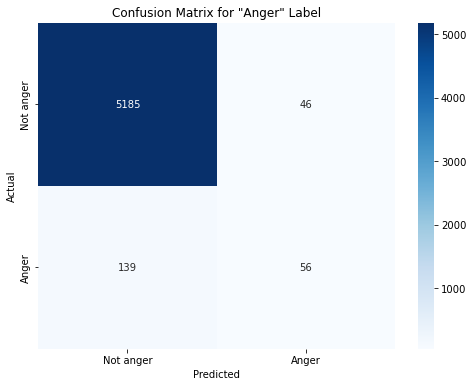

In [40]:
# dont know if i display all the emotions at once, so for now lets create heatmap for only one.
# anger
label_idx = target_names.index('anger')

# Extract binary vectors for the chosen label from the actual and predicted matrices
actual_binary = dev_labels_bin[:, label_idx]
predicted_binary = dev_pred_bin[:, label_idx]

# confusion matrix
cm = confusion_matrix(actual_binary, predicted_binary)

# plot plot 
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Not anger', 'Anger'], yticklabels=['Not anger', 'Anger'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for "Anger" Label')
plt.show()


## Grouped Taxonomy of Emotions 

In [40]:
mapping = {
"positive": ["amusement", "excitement", "joy", "love", "desire", "optimism", "caring", "pride", "admiration", "gratitude", "relief", "approval"],
"negative": ["fear", "nervousness", "remorse", "embarrassment", "disappointment", "sadness", "grief", "disgust", "anger", "annoyance", "disapproval"],
"ambiguous": ["realization", "surprise", "curiosity", "confusion"]
}

In [41]:
def group_predictions(predictions, mapping):
    grouped_preds = np.zeros((predictions.shape[0], len(mapping)))

    # Iterate over the mapping to sum the probabilities
    for i, group in enumerate(mapping):
        for emotion in mapping[group]:
            # Find the index of the emotion in the original taxonomy
            idx = target_names.index(emotion)
            grouped_preds[:, i] += predictions[:, idx]

    # Choose the predicted class based on the max probability
    predicted_classes = np.argmax(grouped_preds, axis=1)

    return predicted_classes


In [42]:
# target_names

In [43]:
dev_predictions = loaded_model.predict([dev_encodings.input_ids, dev_encodings.token_type_ids, dev_encodings.attention_mask])
predicted_classes = group_predictions(dev_predictions, mapping) 

170/170 [==============================] - 597s 4s/step


In [52]:
def convert_to_new_taxonomy_binary(original_binary_labels, mlb, mapping, emotion_mapping):
    # Convert binary labels to emotion labels
    original_labels = mlb.inverse_transform(original_binary_labels)
    
    # Convert emotion labels to new taxonomy
    new_taxonomy_labels = []
    for labels in original_labels:
        new_labels = set()
        for label in labels:
            emotion_str = emotion_mapping.get(str(label))
            if not emotion_str:  # If the emotion is not in the mapping, skip it
                continue
            for group, emotions in mapping.items():
                if emotion_str in emotions:
                    new_labels.add(group)
        new_taxonomy_labels.append(list(new_labels))
    
    # Binarize for new taxonomy
    new_mlb = MultiLabelBinarizer(classes=['positive', 'negative', 'ambiguous'])
    new_binary_labels = new_mlb.fit_transform(new_taxonomy_labels)

    return new_binary_labels


In [53]:
dev_labels_grouped_bin = convert_to_new_taxonomy_binary(dev_labels_bin, mlb, mapping, emotion_mapping)


In [55]:
dev_labels_grouped_bin

array([[0, 0, 1],
       [0, 1, 1],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0]])

In [58]:
# Convert predicted classes to binary format
predicted_binary = np.zeros((predicted_classes.shape[0], 3))
for i, pred in enumerate(predicted_classes):
    predicted_binary[i, pred] = 1

# Convert the binary labels back to the string representation for the new taxonomy
def binary_to_label(binary_labels, classes):
    labels = []
    for row in binary_labels:
        current_labels = [classes[i] for i, val in enumerate(row) if val]
        labels.append(current_labels)
    return labels

# Convert binary predictions to label names
predicted_labels_list = binary_to_label(predicted_binary, ['positive', 'negative', 'ambiguous'])
true_labels_list = binary_to_label(dev_labels_grouped_bin, ['positive', 'negative', 'ambiguous'])

# Print first 10
for i in range(10):
    print(f"Text: {dev_texts[i]}")
    print(f"True label(s): {', '.join(true_labels_list[i])}")
    print(f"Predicted label(s): {', '.join(predicted_labels_list[i])}")
    print("\n" + "="*50 + "\n")


Text: Is this in New Orleans?? I really feel like this is New Orleans.
True label(s): ambiguous
Predicted label(s): ambiguous


Text: You know the answer man, you are programmed to capture those codes they send you, don’t avoid them!
True label(s): negative, ambiguous
Predicted label(s): positive


Text: I've never been this sad in my life!
True label(s): negative
Predicted label(s): negative


Text: The economy is heavily controlled and subsidized by the government. In any case, I was poking at the lack of nuance in US politics today
True label(s): negative, ambiguous
Predicted label(s): positive


Text: He could have easily taken a real camera from a legitimate source and change the price in Word/Photoshop and then print it out.
True label(s): negative
Predicted label(s): positive


Text: Thank you for your vote of confidence, but we statistically can't get to 10 wins.
True label(s): negative
Predicted label(s): positive


Text: Wah Mum other people call me on my bullshit and I can't